# Emissions Factor Mapping

Requirements:
- Python libraries in `requirements.txt`
- OpenAI API Key inside a `.env` file
- `Python >= 3.9` (although lower versions might still work)

This is mostly an exploration notebook that does the following in a less structured and reusable way:
- Explore the data
- Clean the data
- Call the embeddings model (costs money) and store them into back into csv/pkl
- Visualize the data
- Evaluate the model
- Predict on the precomputed `InterviewDataset.csv` or a new set of item descriptions to mimic an API endpoint

The precomputed embeddings for the item labels are then used to accept POST requests from a FastAPI server in `main.py` to perform new predictions. Full details can be found in the `README`.

In [18]:
# data management
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None # type: ignore

# to read environment variables from .env file
from os import getenv
OPENAI_API_KEY = getenv("OPENAI_API_KEY")

# embeddings utils
from pydantic import BaseModel
from openai.embeddings_utils import get_embedding
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

# optional tokenization library for exploration
from nltk import download
from nltk.tokenize import word_tokenize
download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zhermin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [303]:
# df = pd.read_csv("data/InterviewDataset.csv")
df = pd.read_csv("data/EmbeddingsInterviewDataset.csv")
# df["EMBEDDING"] = df["EMBEDDING"].apply(eval)  # might be needed if embeddings weer saved as strings
df = df.dropna()
df.head()

,ITEM DESCRIPTION,LABELS,EMBEDDING,MATCHES
0,beancurd tau kua 2pcs,tofu | tofu firm | tofu plain | tofu soy bean ...,"[-0.0034859112929552794, 0.0038454895839095116...",tofu soy bean curd | thai meal panang curry ch...
1,turbobleach 5l 401,bleach,"[-0.01637611724436283, -0.007683512754738331, ...",bleach | washing up liquid lemon 500 ml | kyoc...
2,sing ghee tau kwa,tofu | tofu firm | tofu plain | tofu soy bean ...,"[0.0009085177443921566, -0.002711440436542034,...",goat cheese and spinach tart | greek yogurt | ...
3,chill kimchi,white cabbage| white cabbage raw | cabbage | c...,"[0.0111548425629735, 0.0040329559706151485, 0....",chilli | chili sauce | chillies and peppers gr...
4,scissor,office stationary | stationary,"[-0.0282297246158123, -0.015823030844330788, 0...",ladder | shredder machine | desk | cucumber | ...


In [305]:
# emissions_df = pd.read_csv("data/EmissionFactorsData.csv")
emissions_df = pd.read_csv("data/EmbeddingsEmissionFactorsData.csv")
emissions_df["EMBEDDING"] = emissions_df["EMBEDDING"].apply(eval)
emissions_df = emissions_df.dropna()
emissions_df.head()

,ITEM,EMISSIONS_FACTOR,EMBEDDING
0,abondance cheese from cows milk,3.299,"[0.008204663172364235, -0.01198259275406599, 0..."
1,agave,0.699,"[-0.024381104856729507, -0.012690054252743721,..."
2,aioli sauce garlic and olive oil mayonnaise pr...,3.988,"[-0.0036228387616574764, 0.00607079453766346, ..."
3,ajvar relish,3.020,"[-0.008036420680582523, -0.011592728085815907,..."
4,alaska pollock smoked,9.129,"[-0.02317998744547367, 0.017293229699134827, -..."


In [235]:
# clean the train/test dataset by changing to lowercase and removing all special characters

df["ITEM DESCRIPTION"] = df["ITEM DESCRIPTION"].str.casefold().replace(r"[^a-zA-Z0-9\s]", "", regex=True)
df["LABELS"] = df["LABELS"].str.casefold().replace(r"[^a-zA-Z0-9|\s]", "", regex=True)
df.sample(10)

,ITEM DESCRIPTION,LABELS,EMBEDDING
343,tyrrells 40g sea salt cracked black pepper p...,potato chips | potato crisps potato chips | ...,"[-0.020478742197155952, -0.01719505898654461, ..."
119,dressing honey dijon,mustard sauce prepacked | dressing | salad dr...,"[-0.01741979271173477, -0.006166687700897455, ..."
201,power box lids 8001000ml bagasse pulp containe...,pet plastic lid large,"[-0.007875345647335052, -0.028309429064393044,..."
326,apple green,green apple | apple green | apple | apple |...,"[-0.005314643029123545, -0.016715792939066887,..."
224,cooked item soft boiled egg harajuku,soft boiled egg harajuku egg | egg softboiled...,"[-0.0076441047713160515, -0.021010691300034523..."
371,cage free eggs,egg | egg raw | goose egg raw | egg white r...,"[-0.004689768422394991, -0.02146444469690323, ..."
239,lime seedless,lime | lime juice | lime raw | grapes seedl...,"[-0.022157318890094757, -0.003934543114155531,..."
337,rolled oats,rolled oats | oat | rolled oats consumer pac...,"[-0.013769636861979961, -0.019098274409770966,..."
129,cooked item falafel,falafel | falafel fried | falafel mince | fala...,"[0.003575885435566306, -0.007245873101055622, ..."
58,dressing cashew nut and mint dressing vegan,salad dressing prepacked,"[-0.010209094732999802, -0.017823845148086548,..."


In [117]:
# clean the emission items and replace "#DIV/0!" with 0 in the emissions factor column

emissions_df["ITEM"] = emissions_df["ITEM"].str.casefold().replace(r"[^a-zA-Z0-9\s]", "", regex=True)
emissions_df["EMISSIONS_FACTOR"] = emissions_df["EMISSIONS_FACTOR"].replace("#DIV/0!", 0)
emissions_df["EMISSIONS_FACTOR"] = emissions_df["EMISSIONS_FACTOR"].astype(float)
emissions_df.sample(10)

,ITEM,EMISSIONS_FACTOR,EMBEDDING
5331,savin mp 5054spg,202.711,"[-0.024994170293211937, -0.0003668586141429841..."
2213,picodon cheese from goats milk,5.866,"[0.011830747127532959, -0.0030741174705326557,..."
2987,strawberry i,1.996,"[-0.010641812346875668, -0.030401183292269707,..."
3581,dell aw3418dw monitor,142.518,"[0.004154056776314974, 0.0030920542776584625, ..."
1682,madeira wine sauce prepacked,2.791,"[0.0015303082764148712, -0.004270289093255997,..."
655,chicken breast fresh boneless skinless,3.589,"[-1.1159398127347231e-05, -0.00094638718292117..."
2427,prepared pasta salad with vegetable meat or fish,2.523,"[0.004696827381849289, -0.006474741734564304, ..."
351,boiled egg peeled,1.349,"[-0.010403876192867756, -0.005639674607664347,..."
3007,sugar beet sugar,0.378,"[-0.019139450043439865, -0.018699778243899345,..."
809,cod fish stick,2.940,"[-0.004739079624414444, 0.006418618373572826, ..."


In [74]:
# exploring tokenization

word_tokenize(df.sample()["ITEM DESCRIPTION"].values[0])

['nissho', 'doublesided', 'eva', 'foam', 'tape']

In [75]:
# get embeddings using OpenAI's embeddings model API

embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # encoding for text-embedding-ada-002

df["EMBEDDING"] = df["ITEM DESCRIPTION"].apply(
    lambda x: get_embedding(x, embedding_model)
)

In [236]:
df.to_csv("data/EmbeddingsInterviewDataset.csv", index=False)

Text(0.5, 1.0, 'Item Descriptions t-SNE Visualization')

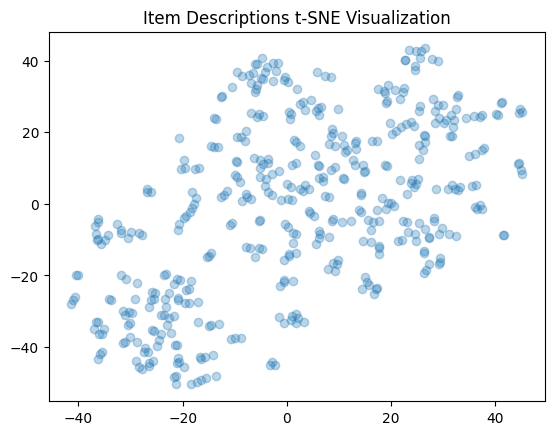

In [26]:
# plot embeddings for the item descriptions using t-SNE to perform dimensionality reduction

matrix = np.array(df["EMBEDDING"].tolist())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

colors = ["red", "darkorange", "gold", "turquiose", "darkgreen"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

plt.scatter(x, y, alpha=0.3)
plt.title("Item Descriptions t-SNE Visualization")

In [91]:
# get embeddings for the emission items

emissions_df["EMBEDDING"] = emissions_df["ITEM"].apply(lambda x: get_embedding(x, embedding_model))

,ITEM,EMISSIONS_FACTOR,EMBEDDING
169,bean sprouts mung raw,1.010,"[-0.006465724669396877, -0.025200456380844116,..."


In [15]:
emissions_df.sample(10)

,ITEM,EMISSIONS_FACTOR,EMBEDDING
4610,lenovo thinkvision p24q,166.006,"[0.014585292898118496, 0.002149283653125167, 0..."
1493,jam raspberry,2.356,"[-0.02061605080962181, -0.026692505925893784, ..."
5474,lanier pro c7100x pro80,436.903,"[0.00865922961384058, 0.0007963211392052472, -..."
3778,dell c2422he monitor,274.352,"[0.010112352669239044, 0.01311727985739708, -0..."
4539,lenovo thinkpad p1thinkpad x1 extreme,117.461,"[0.008855235762894154, 0.0070078386925160885, ..."
6198,tetra top mini with cap eifel c38 250 ml,1.699,"[-0.0034655185882002115, -0.001033873995766043..."
3999,dell s2721hn monitor,248.205,"[0.00396594638004899, 0.0009745814022608101, -..."
5287,ricoh aficio mp 5002,193.563,"[-0.033731501549482346, 0.00023342239728663117..."
2381,potato crisps potato chips,3.575,"[-0.0036547775380313396, -0.017299940809607506..."
1836,mineral sparkling water stdiry bottled strongl...,0.607,"[0.007928343489766121, -0.0003368280304130167,..."


In [290]:
emissions_df.to_csv("data/EmbeddingsEmissionFactorsData.csv", index=False)

In [162]:
# store in pickle file for faster I/O especially for basic deployment

emissions_df.to_pickle("data/EmbeddingsEmissionFactorsData.pkl")

Text(0.5, 1.0, 'Item Labels t-SNE Visualization')

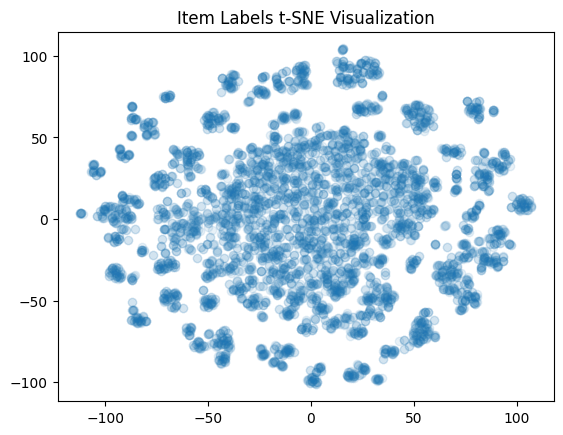

In [311]:
# plot embeddings for the emission items using t-SNE

matrix = np.array(emissions_df["EMBEDDING"].tolist())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

colors = ["red", "darkorange", "gold", "turquiose", "darkgreen"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

plt.scatter(x, y, alpha=0.1)
plt.title("Item Labels t-SNE Visualization")

In [293]:
# calculate cosine similarity between the first item description and all emission items
# then get the top 5 most similar emission items

desc = df.iloc[0]

cosine_similarities = cosine_similarity(
    np.asarray(desc["EMBEDDING"]).reshape(1, -1),
    np.asarray(emissions_df["EMBEDDING"].values.tolist())
)

# Get the indices of the top 5 most similar emission items
top_5_indices = cosine_similarities[0].argsort()[-5:][::-1]

# Get the top 5 most similar emission items
top_5_items = emissions_df.iloc[top_5_indices]
top_5_items["SIMILARITY"] = cosine_similarities[0][top_5_indices]

print(desc["ITEM DESCRIPTION"], ":", desc["LABELS"].split(" | "))
top_5_items

beancurd tau kua 2pcs : ['tofu', 'tofu firm', 'tofu plain', 'tofu soy bean curd']


,ITEM,EMISSIONS_FACTOR,EMBEDDING,SIMILARITY
3106,tofu soy bean curd,1.758,"[-0.0025610539596527815, -0.02217862382531166,...",0.860498
3090,thai meal panang curry chicken,0.929,"[-0.0027667642571032047, -0.011437789537012577...",0.827539
3103,tofu,1.524,"[-0.0019576214253902435, -0.03183453530073166,...",0.822955
2021,noodles with shrimps sautedpanfried,0.718,"[0.01009837444871664, -0.010848884470760822, 0...",0.822948
518,cantonese rice,0.778,"[0.007106873672455549, 0.0037600318901240826, ...",0.822211


In [188]:
# schemas for the emission results and items

class EmissionItem(BaseModel):
    """
    Emission item
    """

    item: str
    emissions_factor: float
    confidence: float


class EmissionResult(BaseModel):
    """
    An emission result with the top 5 most similar emission items
    """

    desc: str
    emission_item: list[EmissionItem]

In [190]:
# functions to get the top n items for a given item description using openai's embeddings model

def clean(text: str) -> str:
    """
    Change to lowercase and remove all special characters
    """
    text = text.casefold()
    text = text.replace(r"[^a-zA-Z0-9\s]", "")
    return text


def get_top_items(desc: str, dataset: pd.DataFrame, n: int = 5) -> EmissionResult:
    """
    Get the top n emission items for a given item description
    """

    desc = clean(desc)
    embedding = get_embedding(desc, embedding_model)

    cosine_similarities = cosine_similarity(
        np.asarray(embedding).reshape(1, -1),
        np.asarray(dataset["EMBEDDING"].values.tolist())
    )

    top_indices = cosine_similarities[0].argsort()[-n:][::-1]

    return EmissionResult(
        desc=desc,
        emission_item=[
            EmissionItem(
                item=dataset.iloc[i]["ITEM"],
                emissions_factor=dataset.iloc[i]["EMISSIONS_FACTOR"],
                confidence=cosine_similarities[0][i]
            )
            for i in top_indices
        ]
    )

In [205]:
# get the top 5 emission items for the first 3 item descriptions (precomputed embeddings)

items = df.iloc[:3]

cosine_similarities = cosine_similarity(
    np.asarray(items["EMBEDDING"].values.tolist()),
    np.asarray(emissions_df["EMBEDDING"].values.tolist())
)

top_items: list[EmissionResult] = []

for desc, sim in zip(items["ITEM DESCRIPTION"], cosine_similarities):
    top_indices = sim.argsort()[-5:][::-1]
    top_items.append(
        EmissionResult(
            desc=desc,
            emission_item=[
                EmissionItem(
                    item=emissions_df.iloc[i]["ITEM"],
                    emissions_factor=emissions_df.iloc[i]["EMISSIONS_FACTOR"],
                    confidence=sim[i]
                )
                for i in top_indices
            ]
        )
    )

for i in range(len(top_items)):
    print(f"{top_items[i].desc}: {items.iloc[i]['LABELS'].split(' | ')}")
    print("---")
    for item in top_items[i].emission_item:
        print(f"{item.item}: {item.emissions_factor} (conf @ {item.confidence:.3%})")
    print()

beancurd tau kua 2pcs: ['tofu', 'tofu, firm', 'tofu, plain', 'tofu, soy bean curd']
---
tofu soy bean curd: 1.758 (conf @ 86.050%)
thai meal panang curry chicken: 0.929 (conf @ 82.754%)
tofu: 1.524 (conf @ 82.296%)
noodles with shrimps sautedpanfried: 0.718 (conf @ 82.295%)
cantonese rice: 0.778 (conf @ 82.221%)

turbobleach 5l 401: ['Bleach']
---
bleach: 0.0 (conf @ 86.146%)
washing up liquid lemon 500 ml: 18.887 (conf @ 82.417%)
kyocera taskalfa 4012i: 295.817 (conf @ 82.364%)
lilac handwash 500 ml: 1.504 (conf @ 82.243%)
antibacterial washing up liquid lavender 500 ml: 21.908 (conf @ 82.197%)

sing ghee tau kwa: ['tofu', 'tofu, firm', 'tofu, plain', 'tofu, soy bean curd']
---
goat cheese and spinach tart: 0.488 (conf @ 81.081%)
greek yogurt: 2.194 (conf @ 81.059%)
yogurt greekstyle ewes milk: 2.609 (conf @ 80.924%)
gouda cheese from cows milk: 2.93 (conf @ 80.893%)
goat cheese: 4.71 (conf @ 80.794%)



In [192]:
# get the top 5 emission items for a given list of item descriptions (calls openai's api)

descriptions = ["tofu", "apple x20"]
descriptions = [clean(desc) for desc in descriptions]
embeddings = [get_embedding(desc, embedding_model) for desc in descriptions]
dataset = pd.read_pickle("EmbeddingsEmissionFactorsData.pkl")

cosine_similarities = cosine_similarity(
    np.asarray(embeddings), np.asarray(dataset["EMBEDDING"].values.tolist())
)

results: list[EmissionResult] = []
for desc, sim in zip(descriptions, cosine_similarities):
    top_indices = sim.argsort()[-5:][::-1]
    results.append(
        EmissionResult(
            desc=desc,
            emission_item=[
                EmissionItem(
                    item=emissions_df.iloc[i]["ITEM"],
                    emissions_factor=emissions_df.iloc[i]["EMISSIONS_FACTOR"],
                    confidence=sim[i]
                )
                for i in top_indices
            ]
        )
    )

for result in results:
    print(result.desc)
    print("---")
    for item in result.emission_item:
        print(f"{item.item}: {item.emissions_factor} (conf @ {item.confidence:.3%})")
    print()

tofu
---
tofu: 1.524 (conf @ 100.000%)
tofu firm: 2.062 (conf @ 93.104%)
tofu soy bean curd: 1.758 (conf @ 92.282%)
tofu plain: 0.783 (conf @ 91.849%)
tempeh: 2.196 (conf @ 88.813%)

apple x20
---
apple iphone x: 51.29 (conf @ 90.138%)
apple iphone xs: 7.767 (conf @ 89.187%)
apple iphone xs max: 59.125 (conf @ 88.524%)
apple iphone xr: 32.275 (conf @ 88.295%)
apple iphone 12 pro max: 35.516 (conf @ 87.882%)



In [301]:
# evaluate the model using Precision for the top 5 predicted items and confidence threshold of 0.8
# also stores the top k emission items into a copy of the dataset

def get_map_at_k(
    dataset: pd.DataFrame,
    emissions_dataset: pd.DataFrame,
    k: int = 5,
    batch_size: int = 32,
) -> tuple[float, pd.DataFrame]:
    """
    Get the precision at k using precalculated embeddings
    """
    df_copy = dataset.copy()

    # get the top k emission items for each item description
    top_items: list[EmissionResult] = []
    for i in range(0, len(dataset), batch_size):
        cosine_similarities = cosine_similarity(
            np.asarray(dataset.iloc[i:i+batch_size]["EMBEDDING"].values.tolist()),
            np.asarray(emissions_dataset["EMBEDDING"].values.tolist())
        )

        for desc, sim in zip(dataset.iloc[i:i+batch_size]["ITEM DESCRIPTION"], cosine_similarities):
            top_indices = sim.argsort()[-k:][::-1]
            top_items.append(
                EmissionResult(
                    desc=desc,
                    emission_item=[
                        EmissionItem(
                            item=emissions_dataset.iloc[i]["ITEM"],
                            emissions_factor=emissions_dataset.iloc[i]["EMISSIONS_FACTOR"],
                            confidence=sim[i]
                        )
                        for i in top_indices
                        if sim[i] > 0.8
                    ]
                )
            )

    # calculate the precision at k for each item description using the correct labels (ignore ordering)
    aps = []
    for i in range(len(top_items)):
        labels = set(dataset.iloc[i]["LABELS"].split(" | "))
        predicted_labels = [item.item for item in top_items[i].emission_item]
        aps.append(
            len(labels.intersection(set(predicted_labels))) / k
        )

        # store the top k emission items into a copy of the dataset
        df_copy.at[i, "MATCHES"] = " | ".join(predicted_labels)

    return sum(aps) / len(aps), df_copy

precision, df_copy = get_map_at_k(df, emissions_df)
print(f"{precision:.3%}")

16.400%


In [298]:
df_copy.to_csv("data/EmbeddingsInterviewDataset.csv", index=False)

In [310]:
df_test = pd.read_csv("data/EmbeddingsInterviewDataset.csv")
df_test.iloc[0]["MATCHES"]

'tofu soy bean curd | thai meal panang curry chicken | tofu | noodles with shrimps sautedpanfried | cantonese rice'